In [2]:
# importing the dependencies modules
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from tqdm import tqdm
from scipy.optimize import minimize
from hurst import compute_Hc
import warnings
warnings.filterwarnings("ignore")

In [3]:
# The code will allow you to switch between the dark and light mode in graphs

from matplotlib import cycler
colors = cycler('color',['#669FEE','#66EE91','#9988DD','#EECC55','#88BB44','#FFBBBB'])
plt.rc('figure',facecolor='#313233')
plt.rc('axes',facecolor='#313233',edgecolor='None',axisbelow=True,grid=True,prop_cycle=colors,labelcolor='gray')

plt.rc('grid',color='#47a4a4') #, linestlye='solid')
plt.rc('xtick',color='gray')
plt.rc('ytick',direction='out',color='gray')
plt.rc('legend',facecolor='#313233',edgecolor='#313233')
plt.rc('text',color='#c9c9c9')

In [4]:
def rsi(value, neutral, window):
	"""

	Input:
	:param value: (type dataframe pandas): Entry values of the stock
	:param neutral:(float) Value of the neutrality, i.e No Action Zone
	:param window: (float) rolling period for RSI calculation

	Output: The function gives the returns of RSI strategy
	:return:
	"""
	# Print error is no Adj Close column is not present
	if "Adj Close" not in value.columns:
		ValueError("Error: No Adj Close column is present")

	value['rsi'] = ta.momentum.RSIIndicator(value['Adj Close'], window=window).rsi()

	"""Long Buy signal"""
	overbuy = 70
	neutral_buy = 50 + neutral

	# Put nan values for te signal long columns
	value['signal_long'] = np.nan
	value['yesterday_rsi'] = value['rsi'].shift(1)
	# We need to define open long signal (Rsi yes>55 and RSI today>55)
	value.loc[(value['rsi'] > neutral_buy) & (value['yesterday_rsi'] < neutral_buy), 'signal_long'] = 1
	# open long signal for false positive (Rsi yes>55 and RSI today<55)
	value.loc[(value['rsi'] < neutral_buy) & (value['yesterday_rsi'] > neutral_buy), 'signal_long'] = 0
	# open long signal for overbuy (Rsi yes>70 and RSI today<70)
	value.loc[(value['rsi'] < overbuy) & (value['yesterday_rsi'] > overbuy), 'signal_long'] = 0

	"""Short Sell signal"""
	oversell = 30
	neutral_sell = 50 - neutral

	# Put the values for the short signal columns
	value['signal_short'] = np.nan

	# We define the Open short signal (RSI yes>45 and RSI today<45)
	value.loc[(value['rsi'] < neutral_sell) & (value['yesterday_rsi'] > neutral_sell), 'signal_short'] = -1

	# We define the Close short signal(Rsi yes<45 and RSI today>45) False signal
	value.loc[(value['rsi'] > neutral_sell) & (value['yesterday_rsi'] < neutral_sell), 'signal_short'] = 0

	# We define the Close short signal (RSI yes<30 and RSI today>30) Oversell
	value.loc[(value['rsi'] < oversell) & (value['yesterday_rsi'] > oversell), 'signal_short'] = 0

	"""Compute the returns"""
	# Compute the percentage of the variation of the stock
	value['pct'] = value['Adj Close'].pct_change(1)

	# Calculate the position
	value['Position'] = (value['signal_short'].fillna(method='ffill') + value['signal_long'].fillna(method='ffill'))

	# Compute the returns
	value['return'] = value['pct'] * (value['Position'].shift(1))

	return value['return']

In [5]:
def beta_function(series):
	sp500 = yf.download('^GSPC')[['Adj Close']].pct_change(1)
	sp500.columns = ['SP500']

	# We concatenate the two dataframe
	value = pd.concat((series, sp500), axis=1)

	# We compute the beta
	beta = np.cov(value[[series.name, "SP500"]].dropna().values,rowvar=False)[0][1] / np.var(value["SP500"].dropna().values)
	return beta


In [6]:

def drawdown_function(series):
	cumulative_sum = series.dropna().cumsum() + 1  # multiplication coefficient
	# compute the max of the cumulative_sum
	# (1,3,1,1,7,1,2,) -> (1,3,3,3,7,7,7)
	running_max = np.maximum.accumulate(cumulative_sum)
	drawdowned = cumulative_sum / running_max - 1
	return drawdowned


In [7]:

def backTest(series):
	# Import the Bechmark
	sp500 = yf.download('^GSPC')['Adj Close'].pct_change(1)
	sp500.name = 'SP500'

	# We concatenate the two dataframe
	value = pd.concat((return_series, sp500), axis=1).dropna()

	# compute the drawdown and max drawdown
	drawdown = drawdown_function(series)
	max_drawdown = -np.min(drawdown)

	"""Plot the Graph"""
	fig, (cum, draw) = plt.subplots(1, 2, figsize=(20, 6))
	fig.suptitle("Backtesting", size=20)

	cum.plot(series.cumsum(), color='#39B3C7')
	cum.plot(value['SP500'].cumsum(), color='#B85A0F')

	cum.legend(["Portfolio", "Benchmark"])
	cum.set_title("Cumulative Returns", size=13)
	cum.set_ylabel("Cumulative Return in %", size=13)

	# Plot the drawdown
	draw.fill_between(drawdown.index, 0, drawdown * 100, color='#C73954', alpha=0.65)

	draw.set_title("Drawdown", size=15)
	draw.set_ylabel("Drawdown in %", size=13)

	# plot the graph
	plt.show()

	"""Compute the statistics"""
	# compute the sortino
	sortino = np.sqrt(252) * series.mean() / series.loc[series < 0].std()

	# compute the beta
	beta = np.cov(value[['return', 'SP500']].values, rowvar=False)[0][1] / np.var(value['SP500'].values)

	# compute the alpha
	alpha = 252 * (series.mean() - beta * series.mean())

	# Print the statistics

	print(f'Sortino: {np.round(sortino, 3)}')
	print(f'Beta: {np.round(beta, 3)}')
	print(f'Alpha: {np.round(alpha, 3)}')
	print(f'MaxDrawdown: {np.round(max_drawdown, 3)}')

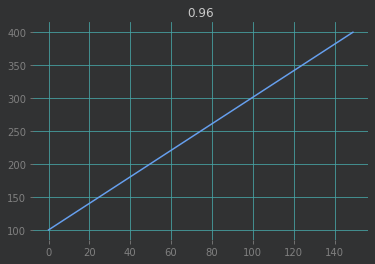

In [8]:
# Hurst Exponent
# It is a statistics that helps in understanding the TimeSeries
# 0.5<Hurst<1 -> Trending movement; 0.5 = Hurst -> Random Walk; 0<Hurst<0.5 -> Anti-persistent movement

# compute Hurst Exponent
array = np.linspace(0, 300, 150) + 100
hurst = compute_Hc(array)
hurst[0]
plt.plot(array)
plt.title(f"{'%.2f' %hurst[0]}")
plt.show()

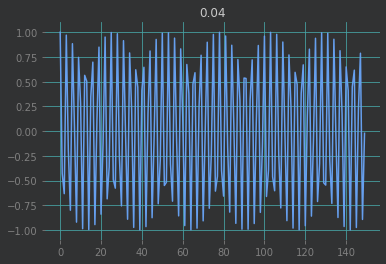

In [9]:
# Anti-persistent
array = np.cos(np.linspace(0,300,150))
hurst = compute_Hc(array)
hurst[0]
plt.plot(array)
plt.title(f"{'%.2f' %hurst[0]}")
plt.show()

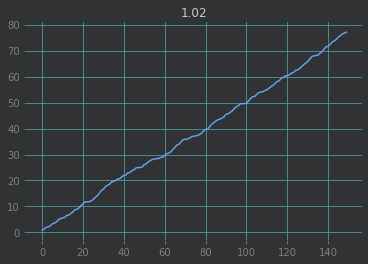

In [10]:
# Random Walk
np.random.seed(56)
array = np.cumsum(np.random.rand(150))
hurst = compute_Hc(array)[0]
plt.plot(array)
plt.title(f"{'%.2f' %hurst}")
plt.show()

In [11]:
# using Names CSV file find the best asset
asset = pd.read_csv('Names.csv')['Symbol']

# Initialize the list
Statistics = []
col = []

for fin in tqdm(asset):
	# check using yfinance
	try:
		print(fin)

		# Download the data of fin
		dataa = yf.download(fin).dropna()
		# Create a list of the statistics
		statistics = list()
		statistics.append(compute_Hc(dataa['Adj Close'])[0])  # Hurst Exponent
		statistics.append(np.sqrt(252) * dataa['Adj Close'].pct_change(1).dropna().std())  # volatility

		statistics.append(beta_function(dataa["Adj Close"].pct_change(1).dropna()))  # beta

		statistics.append(rsi(dataa, 5, 14).mean() * 252)  # RSI
		Statistics.append(statistics)
		col.append(fin)
	except Exception as e:
		pass

# Create dataframe with all statistics
dataframe = pd.DataFrame(Statistics, columns=['Hurst', 'Volatility', 'Beta', 'RSI'], index=col)
print(col, Statistics)
dataframe


  0%|          | 0/152 [00:00<?, ?it/s]

EURUSD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  1%|          | 1/152 [00:06<17:11,  6.83s/it]


EURGBP=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  1%|▏         | 2/152 [00:10<12:26,  4.98s/it]


EURCHF=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  2%|▏         | 3/152 [00:13<10:32,  4.25s/it]


EURCAD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  3%|▎         | 4/152 [00:17<10:02,  4.07s/it]


EURCNY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  3%|▎         | 5/152 [00:21<09:32,  3.90s/it]


EURJPY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  4%|▍         | 6/152 [00:24<09:07,  3.75s/it]


EURSEK=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  5%|▍         | 7/152 [00:29<09:43,  4.02s/it]


EURHUF=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  5%|▌         | 8/152 [00:32<08:59,  3.75s/it]


GBPUSD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  6%|▌         | 9/152 [00:35<08:34,  3.60s/it]


GBPCNY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  7%|▋         | 10/152 [00:39<08:29,  3.59s/it]


GBPJPY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  7%|▋         | 11/152 [00:42<08:11,  3.48s/it]


USDCHF=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  8%|▊         | 12/152 [00:46<08:08,  3.49s/it]


USDCAD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  9%|▊         | 13/152 [00:49<07:51,  3.40s/it]


USDCNY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  9%|▉         | 14/152 [00:52<08:03,  3.50s/it]


USDHKD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 10%|▉         | 15/152 [00:57<08:26,  3.70s/it]


USDSGD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 11%|█         | 16/152 [01:01<08:50,  3.90s/it]


USDINR=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 11%|█         | 17/152 [01:04<08:15,  3.67s/it]


USDMXN=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 18/152 [01:07<07:40,  3.43s/it]


USDPHP=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 12%|█▎        | 19/152 [01:10<07:27,  3.37s/it]


USDTHB=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 20/152 [01:13<07:12,  3.28s/it]


USDMYR=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 21/152 [01:17<07:20,  3.36s/it]


USDZAR=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 22/152 [01:21<07:31,  3.48s/it]


USDJPY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 15%|█▌        | 23/152 [01:24<07:21,  3.42s/it]


AUDJPY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 24/152 [01:28<07:45,  3.63s/it]


NZDUSD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 16%|█▋        | 25/152 [01:31<07:34,  3.58s/it]


BTC-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 26/152 [01:34<07:03,  3.36s/it]


ETH-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 27/152 [01:38<07:03,  3.38s/it]


BNB-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 28/152 [01:41<07:07,  3.44s/it]


USDT-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 29/152 [01:45<07:00,  3.41s/it]


XRP-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 20%|█▉        | 30/152 [01:48<06:52,  3.38s/it]


ADA-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 20%|██        | 31/152 [01:51<06:26,  3.20s/it]


DOGE-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 21%|██        | 32/152 [01:54<06:15,  3.13s/it]


DOT1-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 33/152 [01:56<05:56,  3.00s/it]


UNI3-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 34/152 [01:59<05:47,  2.94s/it]


LTC-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 35/152 [02:03<06:21,  3.26s/it]


BCH-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 24%|██▎       | 36/152 [02:06<06:13,  3.22s/it]


LINK-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 37/152 [02:12<07:40,  4.00s/it]


VET-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 25%|██▌       | 38/152 [02:15<06:53,  3.63s/it]


USDC-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 39/152 [02:19<06:51,  3.64s/it]


SOL1-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 26%|██▋       | 40/152 [02:21<06:19,  3.39s/it]


XLM-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 41/152 [02:25<06:14,  3.37s/it]


FIL-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 42/152 [02:28<06:03,  3.31s/it]


THETA-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 43/152 [02:31<05:54,  3.25s/it]


TRX-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 44/152 [02:34<05:46,  3.20s/it]


XMR-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 30%|██▉       | 45/152 [02:38<06:16,  3.52s/it]


LUNA1-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 30%|███       | 46/152 [02:42<06:01,  3.41s/it]


NEO-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 31%|███       | 47/152 [02:45<05:46,  3.30s/it]


EOS-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 48/152 [02:49<06:04,  3.51s/it]


MIOTA-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 49/152 [02:53<06:30,  3.80s/it]


BSV-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 50/152 [02:56<06:01,  3.55s/it]


AAPL
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 34%|███▎      | 51/152 [03:00<06:13,  3.70s/it]


MSFT
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 52/152 [03:03<05:54,  3.54s/it]


AMZN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 35%|███▍      | 53/152 [03:07<05:56,  3.60s/it]


TSLA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 54/152 [03:10<05:30,  3.37s/it]


FB
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 55/152 [03:13<05:14,  3.24s/it]


GOOG
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 56/152 [03:18<06:08,  3.84s/it]


GOOGL
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 57/152 [03:21<05:54,  3.73s/it]


NVDA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 58/152 [03:25<05:35,  3.57s/it]


PYPL
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 59/152 [03:28<05:11,  3.34s/it]


INTC
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 60/152 [03:31<05:11,  3.38s/it]


CMCSA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 40%|████      | 61/152 [03:34<05:09,  3.40s/it]


NFLX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 41%|████      | 62/152 [03:38<05:23,  3.60s/it]


ADBE
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 41%|████▏     | 63/152 [03:42<05:17,  3.56s/it]


CSCO
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 64/152 [03:46<05:26,  3.71s/it]


PEP
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 65/152 [03:50<05:31,  3.81s/it]


AVGO
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 66/152 [03:53<05:03,  3.53s/it]


TXN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 67/152 [03:57<05:09,  3.65s/it]


TMUS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 45%|████▍     | 68/152 [04:00<04:55,  3.51s/it]


COST
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 45%|████▌     | 69/152 [04:04<04:52,  3.52s/it]


QCOM
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 70/152 [04:07<04:46,  3.49s/it]


AMGN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 71/152 [04:10<04:39,  3.45s/it]


SBUX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 72/152 [04:13<04:27,  3.35s/it]


AMAT
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 73/152 [04:17<04:34,  3.47s/it]


CHTR
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 49%|████▊     | 74/152 [04:20<04:10,  3.21s/it]


INTU
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 75/152 [04:23<04:13,  3.29s/it]


MU
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 50%|█████     | 76/152 [04:27<04:21,  3.44s/it]


BKNG
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 51%|█████     | 77/152 [04:30<04:15,  3.41s/it]


AMD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 51%|█████▏    | 78/152 [04:34<04:17,  3.48s/it]


LRCX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 79/152 [04:38<04:15,  3.51s/it]


ISRG
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 80/152 [04:41<04:09,  3.47s/it]


MDLZ
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 81/152 [04:44<04:00,  3.38s/it]


GILD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 82/152 [04:48<04:03,  3.47s/it]


FISV
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 55%|█████▍    | 83/152 [04:52<04:07,  3.59s/it]


ADP
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 55%|█████▌    | 84/152 [04:56<04:08,  3.66s/it]


ZM
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 85/152 [04:59<04:06,  3.68s/it]


MELI
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 86/152 [05:03<03:58,  3.61s/it]


ATVI
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 87/152 [05:07<04:10,  3.85s/it]


CSX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 88/152 [05:11<04:05,  3.83s/it]


JD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 59%|█████▊    | 89/152 [05:14<03:40,  3.49s/it]


ADSK
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 90/152 [05:17<03:40,  3.56s/it]


BIDU
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 60%|█████▉    | 91/152 [05:24<04:26,  4.37s/it]


ILMN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 61%|██████    | 92/152 [05:27<03:57,  3.96s/it]


ADI
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 61%|██████    | 93/152 [05:31<03:52,  3.94s/it]


NXPI
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 94/152 [05:34<03:38,  3.77s/it]


VRTX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 62%|██████▎   | 95/152 [05:37<03:23,  3.57s/it]


KLAC
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


 63%|██████▎   | 96/152 [05:43<04:04,  4.36s/it]

MRNA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 97/152 [05:48<03:59,  4.35s/it]


PDD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 98/152 [05:52<04:02,  4.50s/it]


REGN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 65%|██████▌   | 99/152 [05:58<04:08,  4.68s/it]


KHC
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 100/152 [06:02<04:01,  4.65s/it]


MNST
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 66%|██████▋   | 101/152 [06:06<03:46,  4.45s/it]


KDP
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 102/152 [06:10<03:37,  4.35s/it]


MAR
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 103/152 [06:16<03:49,  4.68s/it]


ASML
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 104/152 [06:21<03:51,  4.82s/it]


WBA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 105/152 [06:26<03:48,  4.85s/it]


WDAY
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 70%|██████▉   | 106/152 [06:29<03:21,  4.39s/it]


ROST
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 70%|███████   | 107/152 [06:33<03:08,  4.20s/it]


ALGN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 71%|███████   | 108/152 [06:37<02:59,  4.07s/it]


EXC
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 109/152 [06:41<03:02,  4.24s/it]


MCHP
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 110/152 [06:45<02:47,  3.98s/it]


AEP
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 111/152 [06:48<02:42,  3.96s/it]


EBAY
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 74%|███████▎  | 112/152 [06:52<02:32,  3.81s/it]


CTSH
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 113/152 [06:55<02:24,  3.71s/it]


IDXX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 75%|███████▌  | 114/152 [06:59<02:24,  3.80s/it]


BIIB
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 115/152 [07:03<02:16,  3.69s/it]


EA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 76%|███████▋  | 116/152 [07:06<02:09,  3.59s/it]


CDNS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 117/152 [07:11<02:17,  3.94s/it]


SNPS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 118/152 [07:15<02:16,  4.01s/it]


LULU
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 119/152 [07:18<02:04,  3.78s/it]


MTCH
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 120/152 [07:22<01:59,  3.73s/it]


DOCU
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 80%|███████▉  | 121/152 [07:25<01:45,  3.39s/it]


XEL
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 80%|████████  | 122/152 [07:29<01:48,  3.61s/it]


CTAS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 81%|████████  | 123/152 [07:32<01:45,  3.65s/it]


ORLY
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 124/152 [07:36<01:38,  3.53s/it]


DXCM
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 125/152 [07:39<01:33,  3.47s/it]


PAYX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 126/152 [07:43<01:36,  3.72s/it]


MRVL
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 84%|████████▎ | 127/152 [07:47<01:31,  3.67s/it]


ALXN
[*********************100%***********************]  1 of 1 completed

 84%|████████▍ | 128/152 [07:47<01:06,  2.76s/it]



1 Failed download:
- ALXN: No data found, symbol may be delisted
PCAR
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 85%|████████▍ | 129/152 [07:51<01:09,  3.00s/it]


NTES
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 130/152 [07:54<01:08,  3.09s/it]


XLNX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 131/152 [07:58<01:08,  3.25s/it]


SWKS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 132/152 [08:02<01:06,  3.34s/it]


ANSS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 133/152 [08:05<01:03,  3.33s/it]


PTON
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 134/152 [08:09<01:03,  3.51s/it]


TEAM
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 135/152 [08:12<00:58,  3.41s/it]


VRSK
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 136/152 [08:15<00:53,  3.32s/it]


FAST
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 90%|█████████ | 137/152 [08:19<00:52,  3.50s/it]


OKTA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 138/152 [08:22<00:47,  3.40s/it]


DLTR
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 91%|█████████▏| 139/152 [08:25<00:43,  3.34s/it]


CPRT
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 140/152 [08:30<00:44,  3.67s/it]


SGEN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 141/152 [08:33<00:39,  3.59s/it]


SIRI
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 142/152 [08:36<00:34,  3.49s/it]


MXIM
[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 143/152 [08:37<00:23,  2.59s/it]



1 Failed download:
- MXIM: No data found, symbol may be delisted
CDW
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 95%|█████████▍| 144/152 [08:41<00:23,  2.99s/it]


VRSN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 95%|█████████▌| 145/152 [08:44<00:21,  3.02s/it]


SPLK
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 146/152 [08:47<00:18,  3.04s/it]


CERN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 147/152 [08:50<00:15,  3.15s/it]


TCOM
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 148/152 [08:54<00:13,  3.25s/it]


INCY
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 149/152 [08:57<00:09,  3.22s/it]


CHKP
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 99%|█████████▊| 150/152 [09:01<00:06,  3.37s/it]


FOXA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 151/152 [09:04<00:03,  3.17s/it]


FOX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

100%|██████████| 152/152 [09:06<00:00,  3.60s/it]


['EURUSD=X', 'EURGBP=X', 'EURCHF=X', 'EURCAD=X', 'EURCNY=X', 'EURJPY=X', 'EURSEK=X', 'EURHUF=X', 'GBPUSD=X', 'GBPCNY=X', 'GBPJPY=X', 'USDCHF=X', 'USDCAD=X', 'USDCNY=X', 'USDHKD=X', 'USDSGD=X', 'USDINR=X', 'USDMXN=X', 'USDPHP=X', 'USDTHB=X', 'USDMYR=X', 'USDZAR=X', 'USDJPY=X', 'AUDJPY=X', 'NZDUSD=X', 'BTC-USD', 'ETH-USD', 'BNB-USD', 'USDT-USD', 'XRP-USD', 'ADA-USD', 'DOGE-USD', 'DOT1-USD', 'UNI3-USD', 'LTC-USD', 'BCH-USD', 'LINK-USD', 'VET-USD', 'USDC-USD', 'SOL1-USD', 'XLM-USD', 'FIL-USD', 'THETA-USD', 'TRX-USD', 'XMR-USD', 'LUNA1-USD', 'NEO-USD', 'EOS-USD', 'MIOTA-USD', 'BSV-USD', 'AAPL', 'MSFT', 'AMZN', 'TSLA', 'FB', 'GOOG', 'GOOGL', 'NVDA', 'PYPL', 'INTC', 'CMCSA', 'NFLX', 'ADBE', 'CSCO', 'PEP', 'AVGO', 'TXN', 'TMUS', 'COST', 'QCOM', 'AMGN', 'SBUX', 'AMAT', 'CHTR', 'INTU', 'MU', 'BKNG', 'AMD', 'LRCX', 'ISRG', 'MDLZ', 'GILD', 'FISV', 'ADP', 'ZM', 'MELI', 'ATVI', 'CSX', 'JD', 'ADSK', 'BIDU', 'ILMN', 'ADI', 'NXPI', 'VRTX', 'KLAC', 'MRNA', 'PDD', 'REGN', 'KHC', 'MNST', 'KDP', 'MAR', 'A

,Hurst,Volatility,Beta,RSI
EURUSD=X,0.438500,0.116933,0.127516,-0.025937
EURGBP=X,0.514215,0.082665,-0.033917,-0.026768
EURCHF=X,0.540969,0.078649,0.095291,-0.009352
EURCAD=X,0.453388,0.092137,-0.085868,-0.022970
EURCNY=X,0.459657,0.130269,0.070252,-0.118299
...,...,...,...,...
TCOM,0.525706,0.505835,1.699411,0.034896
INCY,0.507495,0.658131,1.956862,0.138341
CHKP,0.487696,0.520497,1.757701,-0.030784
FOXA,0.520203,0.385882,1.878745,-0.085540


In [12]:
# Extract the class of the asset
cluster = pd.read_csv('Names.csv',index_col='Symbol')
del cluster['Unnamed: 0']
cluster

,dummy
Symbol,
EURUSD=X,Currency
EURGBP=X,Currency
EURCHF=X,Currency
EURCAD=X,Currency
EURCNY=X,Currency
...,...
TCOM,Asset
INCY,Asset
CHKP,Asset


In [13]:
# Concat the type of asset and the statistics
dataframe = pd.concat([cluster,dataframe],axis=1).dropna()
dataframe

,dummy,Hurst,Volatility,Beta,RSI
EURUSD=X,Currency,0.438500,0.116933,0.127516,-0.025937
EURGBP=X,Currency,0.514215,0.082665,-0.033917,-0.026768
EURCHF=X,Currency,0.540969,0.078649,0.095291,-0.009352
EURCAD=X,Currency,0.453388,0.092137,-0.085868,-0.022970
EURCNY=X,Currency,0.459657,0.130269,0.070252,-0.118299
...,...,...,...,...,...
TCOM,Asset,0.525706,0.505835,1.699411,0.034896
INCY,Asset,0.507495,0.658131,1.956862,0.138341
CHKP,Asset,0.487696,0.520497,1.757701,-0.030784
FOXA,Asset,0.520203,0.385882,1.878745,-0.085540


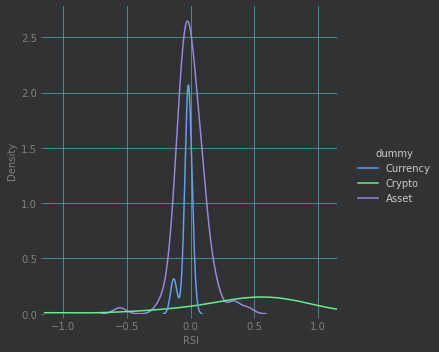

In [14]:
# Plot density distribution of the assest returns
# Plot the densities
sns.displot(data=dataframe, x="RSI",kind='kde', hue="dummy")

# limit the axis
plt.xlim((-1.15,1.15))
plt.show()

In [15]:
# Describe the curreny
dataframe.loc[dataframe["dummy"] == 'Currency'].describe()

,Hurst,Volatility,Beta,RSI
count,25.000000,25.000000,25.000000,25.000000
mean,0.504295,0.100109,0.011365,-0.030522
std,0.051169,0.035844,0.192818,0.042271
min,0.393977,0.010854,-0.419845,-0.146629
25%,0.470308,0.082422,-0.085868,-0.026996
50%,0.497768,0.095109,-0.000292,-0.024278
75%,0.540969,0.125406,0.113765,-0.007186
max,0.643444,0.173963,0.474216,0.022010


In [16]:
# Describe the crypto
dataframe.loc[dataframe["dummy"] == 'Crypto'].describe()

,Hurst,Volatility,Beta,RSI
count,25.000000,25.000000,25.000000,25.000000
mean,0.515312,1.486256,1.440187,0.386728
std,0.045054,1.509386,0.729137,0.494755
min,0.397829,0.069460,-0.126839,-1.236964
25%,0.495470,1.111830,0.998796,0.254347
50%,0.519745,1.259839,1.437132,0.463731
75%,0.545410,1.410942,2.026728,0.718609
max,0.610451,8.391751,2.483677,1.078928


In [17]:
# Describe the assest
dataframe.loc[dataframe["dummy"] == 'Asset'].describe()

,Hurst,Volatility,Beta,RSI
count,100.000000,100.000000,100.000000,100.000000
mean,0.562984,0.459591,1.512126,-0.001026
std,0.036391,0.137277,0.420539,0.121979
min,0.487696,0.207839,0.223730,-0.556468
25%,0.536771,0.356901,1.246996,-0.065282
50%,0.563526,0.464766,1.542833,-0.009821
75%,0.588892,0.557690,1.797937,0.055734
max,0.650227,0.827222,2.528624,0.446306


In [18]:
dataframe.describe()

,Hurst,Volatility,Beta,RSI
count,150.000000,150.000000,150.000000,150.000000
mean,0.545257,0.570788,1.250009,0.058683
std,0.047660,0.752184,0.720229,0.267181
min,0.393977,0.010854,-0.419845,-1.236964
25%,0.514740,0.289001,0.902128,-0.052326
50%,0.546463,0.455081,1.430436,-0.008886
75%,0.578635,0.583667,1.764134,0.086745
max,0.650227,8.391751,2.528624,1.078928


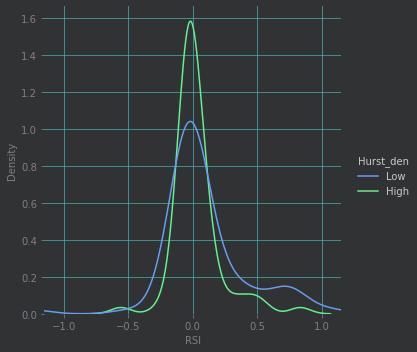

In [19]:
# We are going to plot density of startegy returns by Hurst
dataframe['Hurst_den'] = "Low"
dataframe.loc[dataframe['Hurst']>0.55, 'Hurst_den'] = "High"

# Plot the density
sns.displot(data=dataframe, x="RSI", kind='kde', hue="Hurst_den")
# limit and plot the graph
plt.xlim(-1.15,1.15)
plt.show()

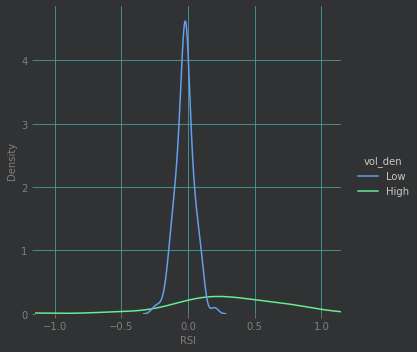

In [20]:
# We are going to plot density of startegy returns by Volatility
dataframe['vol_den'] = "Low"
dataframe.loc[dataframe['Volatility']>0.57, 'vol_den'] = "High"

# Plot the density
sns.displot(data=dataframe, x="RSI", kind='kde', hue="vol_den")
# limit and plot the graph
plt.xlim(-1.15,1.15)
plt.show()

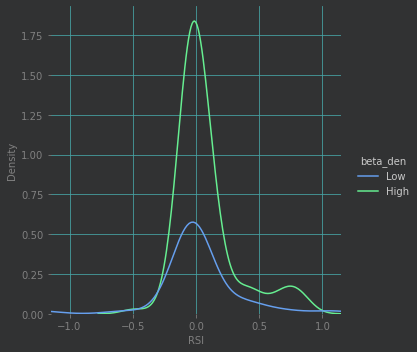

In [21]:
# We are going to plot density of startegy returns by class of asset
dataframe['beta_den'] = "Low"
dataframe.loc[dataframe['Beta']>1, 'beta_den'] = "High"

# Plot the density
sns.displot(data=dataframe, x="RSI", kind='kde', hue="beta_den")
# limit and plot the graph
plt.xlim((-1.15,1.15))
plt.show()